In [1]:
import sys
import glob;
import re;
import csv
import math

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

import numpy as np
import numpy.linalg 
import geom
import matplotlib.image as image
import matplotlib.pyplot as plt
import matplotlib as mpl

import MRDataAnalysis
from MRDataAnalysis import rescale as rescaleIm
from imagemanip import fwhm1D

import scipy.interpolate as snt
import scipy.ndimage.filters as sflt

import pandas
import nibabel

import matplotlib.gridspec as gridspec

def vectorstr2arr(panda_vec_string,dtype=np.float):
    return np.array(list(map(float,panda_vec_string[1:-1].split())), dtype=dtype)


def grnumaxis(nslc):
    sqr=np.sqrt(nslc)
    if np.abs(np.mod( sqr, 1.0))<1e-16:
        #is perfect square
        nnc=int(sqr)
    else:
        nnc=floor(sqr)+1
    
    nnr = ceil(nslc/nnc)

    return (nnr,nnc)
def grax_ij(slidx, nnr,nnc):
    j_ax = np.mod(slidx,nnc)
    i_ax = floor(slidx/nnc)
    return (i_ax,j_ax)


In [3]:
def readNDI_csv(filename, nmax=None, startcol=0):
    csvfile=open(filename)
    reader=csv.reader(csvfile)
    text=list(reader)
    csvfile.close()
    
    if re.search( 'Tools', text[0][0]):
        text.pop(0)
        
    if nmax is not None:
        text = text[0:nmax]
    
    err = np.array( list(map( lambda x: x[startcol + 12], text )), dtype='float')
    txyz = np.array( list(map( lambda x: x[startcol + 9:startcol + 12], text )), dtype='float')
    q0xyz = np.array( list(map( lambda x: x[startcol + 5:startcol + 9], text )), dtype='float')
    
    return (q0xyz, txyz, err)

def read_fcsv(filename, nmax=None, headerlength=3):
    csvfile=open(filename)
    reader=csv.reader(csvfile)
    text=list(reader)
    csvfile.close()
    
    for n in range(headerlength):
        text.pop(0)
        
    if nmax is not None:
        text = text[0:nmax]
    
    xyz = np.array( list(map( lambda x: x[1:4], text )), dtype='float')

    return xyz

def write_fcsv(filename, vectors,filemode="w",end="\n"):
    text_file = open(filename, filemode)
    text_file.write("# Markups fiducial file version = 4.6"+end)
    text_file.write("# CoordinateSystem = 0"+end)
    text_file.write("# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID"+end)
    for i in range(len(vectors)):
        (x,y,z)=vectors[i]
        text_file.write( "vtkMRMLMarkupsFiducialNode_%d,%0.4f,%0.4f,%0.4f,0,0,0,1,1,1,1,absphys-%d,,vtkMRMLScalarVolumeNode1"+end%(i,x,y,z,i))
    text_file.close()

In [4]:
scan_fids = read_fcsv("/Users/vchaplin/Data/7T/20170119/Fids_scan9.fcsv")

In [5]:
f=glob.glob("/Users/vchaplin/Data/7T/20170119/opti/fids_rel_*csv")


phys_fids_xyz =  np.zeros([len(f),3])
phys_fids_quat = np.zeros([len(f),4])

for fi in range(len(f)):
    (q0xyz, txyz, err) = readNDI_csv(f[fi])
    phys_fids_xyz[fi,:]=np.mean(txyz,axis=0)
    phys_fids_quat[fi,:]=np.mean(q0xyz,axis=0)

In [5]:
(junk,calibration_xyz,junk) = readNDI_csv("/Users/vchaplin/Data/7T/20170119/opti/stylus340_wrt_body339.csv")
calibration_xyz = np.mean(calibration_xyz,axis=0)

In [6]:
phys_fids_xyz

array([[ 27.7965  , -11.943025, -59.013675],
       [-26.456425, -48.67815 , -62.484975],
       [-67.018275, -13.42675 , -68.710175],
       [-33.10445 ,  47.060975, -57.204775],
       [-11.294575,  47.904575, -58.278975]])

In [7]:
scan_fids

array([[ 11.9474 ,  61.926  , -53.9258 ],
       [ 29.653  ,  59.0869 ,   7.46388],
       [-15.8109 ,  50.926  ,  37.6894 ],
       [-64.8392 ,  58.926  , -15.1443 ],
       [-57.4396 ,  58.926  , -37.343  ]])

In [15]:
calibration_xyz

array([ -21.61407,   -0.2143 , -119.30163])

In [125]:
text_file = open("/Users/vchaplin/Data/7T/20170119/Fids_phys_abs.fcsv", "w")
text_file.write("# Markups fiducial file version = 4.6\n")
text_file.write("# CoordinateSystem = 0\n")
text_file.write("# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID\n")
for i in range(len(phys_fids_xyz)):
    (x,y,z)=phys_fids_xyz[i]
    text_file.write( "vtkMRMLMarkupsFiducialNode_%d,%0.4f,%0.4f,%0.4f,0,0,0,1,1,1,1,absphys-%d,,vtkMRMLScalarVolumeNode1\n"%(i,x,y,z,i))
text_file.close()

In [6]:
#[R,t,FRE,FREcomponents] = point_register(X,Y,w,n_t)
w=None
n_t=None
X = phys_fids_xyz
#Y = X + 5.001*np.random.random(X.shape) + 100
Y = scan_fids
def point_register(X,Y,w=None,n_t=None):
    """
    Adapted from 
    % [R,t,FRE,FREcomponents] = POINT_REGISTER(X,Y,w,n_t)
    % Find R,t such that R*X + t*ones(1,N) ~ Y,
    % where N = number of columns of X and Y. Optional weightings may be
    % specified in the vector w. n_t is the number of points which contribute
    % to the calculation of the translation vector t. If n_t is zero,
    % then t is all zeros. If n_t is omitted, then all points contribute to t.
    %
    % Author: J. Michael Fitzpatrick
    % Creation: Fall 2001 (for my CS 357 course, Image Processing)
    %
    % Each column of X and each column of Y represents a
    % K-dimensional point, where K is the number of rows.
    % X and Y must have the same number of points (columns).
    % FRE = RMS fiducial registration error.
    % FREcomponents = R*X + t*ones(1,N) - Y.
    % Uses algorithm 8.1 and notation of pp. 469-70 of
    % J. Michael Fitzpatrick, Derek L. G. Hill, and Calvin R. Maurer, Jr.,
    % "Image Registration", Chapter 8 of "Handbook of Medical Imaging,
    % Volume 2, Medical Image Processing and Analysis",
    % Milan Sonka and J. Michael Fitzpatrick, eds., SPIE Press,
    % Bellingham, Wa, 2000.
    """

    #N x 3 in most cases
    (N,K) = np.shape(X)
    (Ny,Ky) = np.shape(Y)

    if w is None:
        w = np.ones(N)
    if n_t is None:
        n_t = N

    wsq = w**2
    wsq_normed = wsq/np.sum(wsq) 


    #X*np.transpose(np.repeat([wsq_normed],3,axis=0))
    Xavg = np.mean(X,axis=0)
    Yavg = np.mean(Y,axis=0)
    X0 = X - Xavg
    Y0 = Y - Yavg

    H = np.transpose(X0).dot( np.diag(wsq_normed).dot( Y0 ) )

    (U,S,V) = numpy.linalg.svd(H)
    #evidently need this when comparing to fitzpatrick code
    V = np.transpose(V)
    U = np.transpose(U)

    D = np.diag(np.append(np.ones(K-1), numpy.linalg.det(np.dot(V,U)) ))

    R = V.dot( np.dot(D,U) )
    t = Yavg - R.dot(Xavg)


    FREcomp = np.transpose( np.tensordot( R,X,axes=[1,1]) ) + t - Y
    FRE = np.sqrt( np.sum(FREcomp*FREcomp)/np.sum(wsq)  )

    return (R,t,FRE)


In [7]:
(R_phys2scan,t_phys2scan,FRE) = point_register(phys_fids_xyz, scan_fids)
(R_scan2phys,t_scan2phys,FRE) = point_register(scan_fids,phys_fids_xyz)

def apply_trfm(vec, R,t):
    if vec.ndim>1:
        return np.transpose( np.tensordot( R,vec,axes=[1,1]) ) + t
    else:
        return R.dot(vec) + t

def xyz2scan(xyz):
    return apply_trfm(xyz,R_phys2scan,t_phys2scan)
    
def scan2xyz(mps):
    return apply_trfm(mps,R_scan2phys,t_scan2phys)

FRE

1.2761392921432488

In [311]:
slicer_R = np.array([[.31,.01,-.95],[-.95,-.05,-.31],[-.06,1.0,0]])
slicer_t = np.array([-28.46,-14.78,-120.13])

np.transpose( np.tensordot( slicer_R, scan_fids,axes=[1,1]) ) + slicer_t - phys_fids_xyz

array([[-0.704036 , -0.566307 ,  0.092831 ],
       [ 0.689038 ,  0.4596522, -0.337305 ],
       [-1.638774 , -0.562909 ,  0.454829 ],
       [-0.479357 ,  1.504698 , -0.108873 ],
       [ 1.093409 ,  0.513075 ,  0.521351 ]])

In [13]:
parfile1 = "/Users/vchaplin/Data/7T/20170119/XMLPARREC/Caskey999_07_01_09.40.01_(WIP_WIP_TemperatureMapping).PAR"

imgObj=nibabel.load(parfile1,scaling='fp')
imgData=imgObj.get_data()

header=imgObj.get_header()
numdyns = header.general_info['max_dynamics']

Taffine=imgObj.header.get_affine()
invTempAffine=np.linalg.inv(Taffine)

(M1,R1,I1,P1)=MRDataAnalysis.parse_scan_parts(imgData,num_parts=4)

(Nx,Ny,Nz,numdyns)=M1.shape

complexImgSeries = R1 + 1j*I1
    
TE_ms = 10
B0_T = 7.0
ang2temp = 1.0 / (42.576*0.01*B0_T*TE_ms*1e-3*2*math.pi)
    
basedynes=[0,1]
baseline=np.mean( complexImgSeries[:,:,:,basedynes], axis=3 ) 

tempSeries = np.zeros(complexImgSeries.shape)

for dn in range(0,numdyns):
    tempSeries[:,:,:,dn] = ang2temp*np.angle( baseline * np.conj(complexImgSeries[:,:,:,dn]) )

In [14]:
calibration_xyz

array([ -21.61407,   -0.2143 , -119.30163])

In [610]:
predictedVoxel = invTempAffine[0:3,0:3].dot(xyz2scan(calibration_xyz)) + invTempAffine[0:3,3]
predictedVoxel

array([ 38.02963228,  36.95245934,   1.47249173])

In [634]:
invTempAffine

array([[ -0.60132291,  -0.        ,  -0.        ,  30.98947685],
       [ -0.        ,  -0.60132291,  -0.        ,  37.03397474],
       [  0.        ,   0.        ,   0.5       ,   7.01      ],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

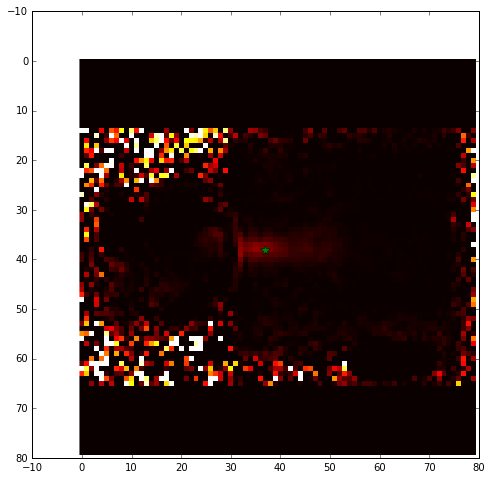

In [594]:
plt.figure(figsize=(8,8))
plt.imshow(tempSeries[:,:,1,3],vmin=0,vmax=10, interpolation='none',cmap=image.cm.hot)
plt.plot( predictedVoxel[[1]], predictedVoxel[[0]], '*',color='g',markersize=10)

#### Plot Thermal profile from center of fiducials to focus ####

In [611]:
fidocenter_phys = np.mean(phys_fids_xyz,axis=0) #center of fiducial points on the cone

axial_vec_phys = (calibration_xyz - fidocenter_phys) #vector from center to pulse echo calibration

sMag = np.sqrt( np.sum(axial_vec_phys**2))
s = axial_vec_phys /uMag

ds = 1.0
axpoints = np.arange(0,2*sMag+ds,ds)
#trpoints = np.arange()
axial_path_phys = fidocenter_phys + np.outer(axpoints, s)
axial_path_RAS = xyz2scan(axial_path_phys)
axial_path_mps = apply_trfm( axial_path_RAS, invTempAffine[0:3,0:3], invTempAffine[0:3,3] )

(path_low_bound, path_up_bound) = (np.floor(np.min(axial_path_mps,axis=0)).astype(int), np.ceil(np.max(axial_path_mps,axis=0)).astype(int))

(vox0, vox1, vox2) = tuple( map( lambda a,b: np.arange(a, b+1), path_low_bound, path_up_bound ) )

vm0, vm1, vm2 = np.meshgrid( vox0, vox1, vox2, indexing='ij')

temppoints = np.array([vm0.flatten(), vm1.flatten(), vm2.flatten()]).transpose() 



In [596]:
temppoints.shape

(3124, 3)

In [612]:
pathTemp = snt.griddata(temppoints, tempSeries[np.ix_(vox0,vox1,vox2,[3])].flatten(), axial_path_mps, fill_value=0, method='linear' )

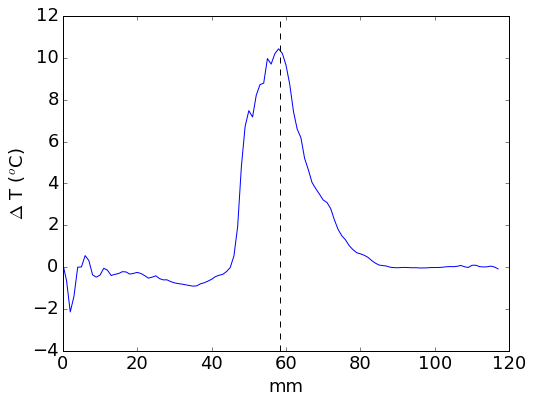

In [613]:
fig=plt.figure(figsize=(8,6))
plt.plot(axpoints, pathTemp)
plt.plot([sMag,sMag],plt.ylim(), '--k')

plt.xlabel('mm',fontsize=18)
plt.ylabel('$\Delta$ T ($^o$C)',fontsize=18)
plt.gca().tick_params(labelsize=18)

In [614]:
fig.savefig('/Users/vchaplin/Data/7T/20170119/tempProfile_802kHz_scan7.png',dpi=300)

In [615]:
arfifile = "/Users/vchaplin/Data/7T/20170119/XMLPARREC/Caskey999_16_01_11.13.46_(WIP_ARFI_tra_off).PAR"
arfifile = "/Users/vchaplin/Data/7T/20170119/XMLPARREC/Caskey999_14_01_10.47.46_(WIP_ARFI_cor).PAR"
arfifile = "/Users/vchaplin/Data/7T/20170119/XMLPARREC/Caskey999_12_01_10.13.24_(WIP_ARFI_tra).PAR"
arfiObj=nibabel.load(arfifile,scaling='fp')
arfiData=arfiObj.get_data()

invArfiAffine=np.linalg.inv(arfiObj.header.get_affine())

(M1,R1,I1,P1)=MRDataAnalysis.parse_scan_parts(arfiData,num_parts=4)

complexIm = R1+1j*I1
phaseChange = np.angle(complexIm[:,:,:,0]*np.conjugate(complexIm[:,:,:,1]))

predictedVoxel = invArfiAffine[0:3,0:3].dot(xyz2scan(calibration_xyz)) + invArfiAffine[0:3,3]
predictedVoxel

array([ 188.15183496,  185.79329946,    2.73271868])

In [625]:
xyz2scan(fidocenter_phys)

array([-19.29786 ,  57.95818 , -12.251964])

In [627]:
centervox=apply_trfm( xyz2scan(fidocenter_phys), invArfiAffine[0:3,0:3], invArfiAffine[0:3,3] )

In [ ]:
apply_trfm

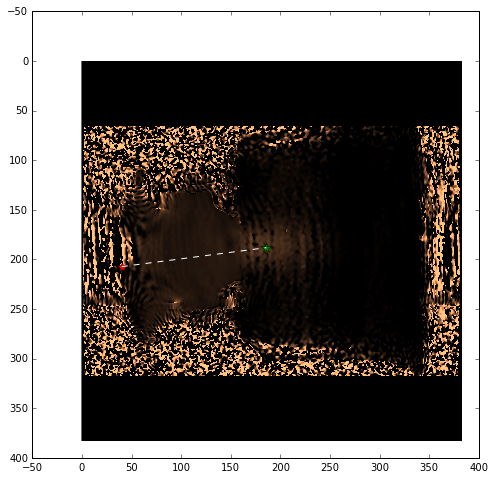

In [689]:
plt.figure(figsize=(8,8))
plt.imshow(phaseChange[:,:,1],vmin=0,vmax=1.57, interpolation='none',cmap=image.cm.copper)
plt.plot( predictedVoxel[[1]], predictedVoxel[[0]], '*',color='g',markersize=10)
plt.plot( centervox[[1]], centervox[[0]], '*',color='r',markersize=10)
plt.plot([centervox[1],predictedVoxel[1]], [centervox[0],predictedVoxel[0]], 'w--' )

(170, 210)

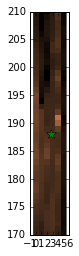

In [447]:
#fig=plt.figure(figsize=plt.figaspect(10))
plt.imshow(phaseChange[:,187,:],vmin=0,vmax=1.57, interpolation='none',cmap=image.cm.copper)
plt.plot( predictedVoxel[[2]], predictedVoxel[[0]], '*',color='g',markersize=10)
plt.ylim([170,210])

In [682]:
arfi_axpoints = np.arange(0.4*sMag,1.6*sMag+ds,ds)

axial_path_phys = fidocenter_phys + np.outer(arfi_axpoints, s)
axial_path_RAS = xyz2scan(axial_path_phys)
axial_path_arfi = apply_trfm( axial_path_RAS, invArfiAffine[0:3,0:3], invArfiAffine[0:3,3] )

(path_low_bound, path_up_bound) = (np.floor(np.min(axial_path_arfi,axis=0)).astype(int), np.ceil(np.max(axial_path_arfi,axis=0)).astype(int))

(vox0, vox1, vox2) = tuple( map( lambda a,b: np.arange(a, b+1), path_low_bound, path_up_bound ) )

vm0, vm1, vm2 = np.meshgrid( vox0, vox1, vox2, indexing='ij')

arfipoints = np.array([vm0.flatten(), vm1.flatten(), vm2.flatten()]).transpose() 

In [657]:
path_low_bound, path_up_bound

(array([184, 142,   2]), array([194, 218,   3]))

In [684]:
pathArfi = snt.griddata(arfipoints, phaseChange[np.ix_(vox0,vox1,vox2)].flatten(), axial_path_arfi, fill_value=0, method='linear' )

In [683]:
arfipoints.shape

(13275, 3)

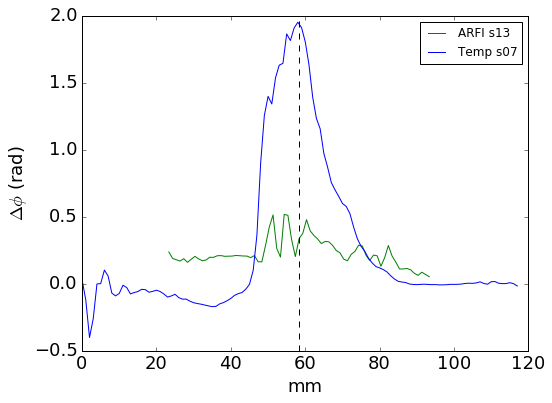

In [685]:
fig=plt.figure(figsize=(8,6))
plt.plot(arfi_axpoints,pathArfi,'g', label='ARFI s13')

plt.xlabel('mm',fontsize=18)
plt.ylabel('$\Delta \phi$ (rad)',fontsize=18)
plt.gca().tick_params(labelsize=18)

plt.plot(axpoints, pathTemp/ ang2temp ,'b', label='Temp s07')

plt.draw()

plt.plot([sMag,sMag], plt.ylim(), '--k')
plt.legend()

In [686]:
fig.savefig('/Users/vchaplin/Data/7T/20170119/Temp_ARFI_802kHz_s07_s13.png',dpi=300)

#### Fiducial fitting ####

In [8]:
thrive = "/Users/vchaplin/Data/7T/20170119/XMLPARREC/Caskey999_09_01_09.48.23_(WIP_WIP_THRIVE_supine_1mmACQ_NSA3).PAR"

thrObj=nibabel.load(thrive,scaling='fp')
thriveData=thrObj.get_data()

affine=thrObj.header.get_affine()
invAffine=np.linalg.inv(affine)

def thrive2ras(x):
    return apply_trfm(x, affine[0:3,0:3], affine[0:3,3] )

In [105]:
apply_trfm(scan_fidos_vox[0], affine[0:3,0:3],0)

array([ -47.2356,  -23.    , -121.6368])

In [10]:
scan_fidos_vox = apply_trfm(scan_fids, invAffine[0:3,0:3], invAffine[0:3,3] )
scan_fidos_vox

array([[ 127.66378378,  328.74810811,   23.        ],
       [  79.81081081,  162.83005405,   25.8391    ],
       [ 202.68621622,   81.13945946,   34.        ],
       [ 335.19513514,  223.93324324,   26.        ],
       [ 315.19621622,  283.92972973,   26.        ]])

In [11]:
np.cross(scan_fidos_vox, scan_fidos_vox[0])

array([[     0.        ,      0.        ,      0.        ],
       [ -4749.46399697,   1463.06862692,   5450.15224637],
       [ -9311.22810811,   -321.21432432,  56274.13971191],
       [ -3396.98621622,  -4390.22972973,  81606.60137531],
       [ -2017.06702703,  -3930.25459459,  67372.61613791]])

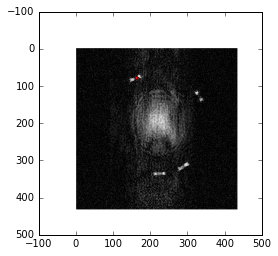

In [12]:
fi=1
plt.imshow(thriveData[:,:,23],cmap=image.cm.gray)
plt.plot( [scan_fidos_vox[fi,1]], scan_fidos_vox[fi,0], 'r*')

In [13]:
def norm(u,axis=0):
    return np.sqrt(np.sum(u**2,axis=axis))
def normalize(u,axis=0):
    return u/np.sqrt(np.sum(u**2,axis=axis))

def in_marker_model(x0, center, normal, h=3.5, d1=3.5/2.0, d2=7.5):
    if normal[2]>0.9999:
        axis = [1,0,0]
    else:
        axis = [0,0,1]
    
    #u1 = normalize(np.cross(normal, axis))
    #u2 = normalize(np.cross(normal, u1))
    
    hv = normal*h
    uv = center - x0
    
    if uv.ndim>1:
        s = np.transpose( np.tensordot( normal,uv,axes=[0,1]) )
        d = norm( np.cross(uv, hv),axis=1 ) / h 
        
        ins = np.logical_and(d> d1, np.logical_and(np.logical_and(s >=0, s <= h), d <= d2 ) )
    else:
        s = normal.dot(uv)
        d = norm( np.cross(uv, hv) ) / h
        ins = s <= h and d <= d2 and d> d1
    
    #s = normal.dot(uv)
    #d = norm( np.cross(uv, hv) ) / h 
    
    #ins = s <= h and d <= d2 and d> d1
    return ins
    

In [14]:
scan_fids

array([[ 11.9474 ,  61.926  , -53.9258 ],
       [ 29.653  ,  59.0869 ,   7.46388],
       [-15.8109 ,  50.926  ,  37.6894 ],
       [-64.8392 ,  58.926  , -15.1443 ],
       [-57.4396 ,  58.926  , -37.343  ]])

In [164]:
scan_fidos_vox

array([[ 127.66378378,  328.74810811,   23.        ],
       [  79.81081081,  162.83005405,   25.8391    ],
       [ 202.68621622,   81.13945946,   34.        ],
       [ 335.19513514,  223.93324324,   26.        ],
       [ 315.19621622,  283.92972973,   26.        ]])

In [281]:

#minslice = np.min( scan_fidos_vox[:,3])
#minslice = np.min( scan_fidos_vox[:,3])

In [288]:
center=scan_fidos_vox[0]
normal=np.array([0.3,0.8,0.1])
normal /= np.sqrt(np.sum(normal**2))


v0 = np.arange(thriveData.shape[0])
v1 = np.arange(thriveData.shape[1])
v2 = np.arange(thriveData.shape[2])
vm0, vm1, vm2 = np.meshgrid( v0,v1,v2, indexing='ij')

meshpoints = thrive2ras( np.transpose( np.array([vm0.flatten(), vm1.flatten(), vm2.flatten()]) ) )
#points = np.transpose( np.array([vm0.flatten(), vm1.flatten(), vm2.flatten()]) )

In [283]:
normal = normalize( affine[0:3,0:3].dot( np.array([-1,1,.5]) ) )

ins = in_marker_model( meshpoints, thrive2ras(center), normal )

mask = ins.reshape(vm0.shape)

In [251]:
mask.shape

(432, 432, 120)

In [38]:
import HookJeeves

In [310]:
scan_fidos_vox[0]

array([ 127.66378378,  328.74810811,   23.        ])

In [ ]:
np.ix_

In [16]:
guess = scan_fidos_vox[2]


v0 = np.arange(-40,40) + guess[0]
v1 = np.arange(-40,40) + guess[1]
v2 = np.arange(-30,30) + guess[2]

v0 = v0[v0>0].astype(int)
v1 = v1[v1>0].astype(int)
v2 = v2[v2>0].astype(int)

vm0, vm1, vm2 = np.meshgrid( v0,v1,v2, indexing='ij')

meshpoints = thrive2ras( np.transpose( np.array([vm0.flatten(), vm1.flatten(), vm2.flatten()]) ) )


datablock = rescaleIm( thriveData[np.ix_(v0,v1,v2)])

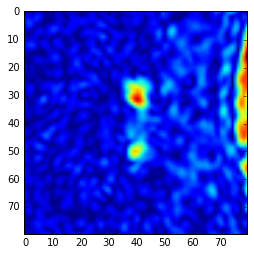

In [444]:
normal = normalize( affine[0:3,0:3].dot( np.array([-1,1,.5]) ) )
ins = in_marker_model( meshpoints, thrive2ras(guess), normal )
mask = ins.reshape(vm0.shape)

plt.figure(figsize=(4,4))
plt.imshow(datablock[:,:,30])
maskoverlay = np.zeros((mask.shape[0],mask.shape[1],4) ) 


gr=np.gradient(mask[:,:,20])
grIM=gr[0]**2 + gr[1]**2

maskoverlay[mask[:,:,20]] = 0.8
maskoverlay[grIM>0] = 1

plt.imshow( maskoverlay)

In [54]:

#datablock=rescaleIm( thriveData )

def objectiveFunc( x,meshpoints=meshpoints, datablock=datablock ):
    """
    x = [center xyz, normal xyz]    
    """
    
    normal = normalize( x[3:6] )

    ins = in_marker_model( meshpoints, thrive2ras(x[0:3]), normal)
    
    mask = ins.reshape(datablock.shape)
    
    return -np.sum(mask*datablock)
    

In [433]:
evalhist = HookJeeves.make_default_evaldict()

In [478]:
x0 = np.array( [guess[0], guess[1], guess[2], 0,0,1 ])
dxinit = np.array( [5,5,1, 0.1,0.1,0.1 ])
tol = np.array( [.1,.1,0.1, 0.01,0.01,0.01 ])

In [455]:
objectiveFunc(x0)

memmap(-598.1717171717172)

In [479]:
ans = HookJeeves.minimize(objectiveFunc, x0, dxinit, 2, tol, evaldict=evalhist )

#RESTART  0
explore{0}
  #discard
explore{1}
 #retain downward
explore{2}
 #retain upward
explore{3}
 #retain upward
explore{4}
  #discard
explore{5}
  #discard
#PATTERN MOVE  0
explore{0}
 #retain upward
explore{1}
 #retain upward
explore{2}
  #discard
explore{3}
 #retain downward
explore{4}
  #discard
explore{5}
 #retain upward
[ 202.68621622   81.13945946   34.            0.            0.            1.        ] [  2.02686216e+02   7.61394595e+01   3.50000000e+01   1.00000000e-01
   0.00000000e+00   1.00000000e+00] [  2.07686216e+02   7.61394595e+01   3.60000000e+01   1.00000000e-01
   0.00000000e+00   1.10000000e+00]  :  None -880.1818181818184 -819.989898989899 False
#RESTART  1
explore{0}
  #discard
explore{1}
  #discard
explore{2}
  #discard
explore{3}
  #discard
explore{4}
  #discard
explore{5}
  #discard
#CONTRACTION, dx ->  [ 2.5   2.5   0.5   0.05  0.05  0.05]
#RESTART  2
explore{0}
  #discard
explore{1}
  #discard
explore{2}
  #discard
explore{3}
 #retain downward
explore{4}

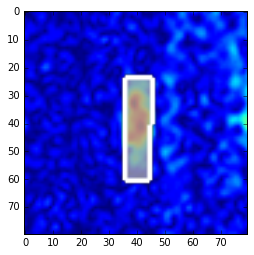

In [481]:
trial_normal = normalize( affine[0:3,0:3].dot( np.array([0,1,0]) ) )
trial_center = scan_fidos_vox[0]

trial_normal = normalize( ans[0][3:6] )
trial_center = ans[0][0:3]

si=trial_center[2].astype(int)

si=34

ins = in_marker_model( meshpoints, thrive2ras(trial_center), trial_normal )

mask = ins.reshape(vm0.shape)

plt.figure(figsize=(4,4))
plt.imshow(datablock[:,:,si])
maskoverlay = np.zeros((mask.shape[0],mask.shape[1],4) ) 


gr=np.gradient(mask[:,:,si])
grIM=gr[0]**2 + gr[1]**2

maskoverlay[mask[:,:,si]] = 0.8
maskoverlay[grIM>0] = 1

plt.imshow( maskoverlay)

In [336]:
ans

(array([  1.27663784e+02,   3.23748108e+02,   2.30000000e+01,
         -1.10000000e+00,   1.30451205e-15,   1.90000000e+00]), 0)

In [369]:
ans

(array([  1.30163784e+02,   3.24998108e+02,   2.30000000e+01,
         -1.88750000e+00,  -2.50000000e-02,   3.16250000e+00]), 0)

In [43]:
zb

memmap(26.77574131716906)

C:\Users\Vandiver\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


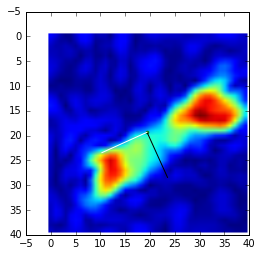

In [48]:
im=datablock[0:,0:,:]

(mx,my,mz) = np.meshgrid( np.arange(im.shape[0]), np.arange(im.shape[1]), np.arange(im.shape[2]), indexing='ij')

xb=np.sum( mx*im ) / np.sum(im)
yb=np.sum( my*im ) / np.sum(im)
zb=np.sum( mz*im ) / np.sum(im)

Ixx = np.sum( ((my-yb)**2 + (mz-zb)**2)*im )
Iyy = np.sum( ((mx-xb)**2 + (mz-zb)**2)*im )
Izz = np.sum( ((mx-xb)**2 + (my-yb)**2)*im )
Ixy = -np.sum( (mx-xb)*(my-yb)*im )
Ixz = -np.sum( (mx-xb)*(mz-zb)*im )
Iyz = -np.sum( (mz-zb)*(my-yb)*im )

w,v = np.linalg.eig([[Ixx,Ixy,Ixz],[Ixy,Iyy,Iyz], [Ixz,Iyz,Izz]])

axv0=v[:,0]
axv1=v[:,1]

im = im[:,:,np.round(zb)]

plt.imshow(im)
plt.plot([yb],[xb],'g.')
plt.plot([yb,yb + 10*axv0[1]], [xb,xb + 10*axv0[0]],'k')
plt.plot([yb,yb + 10*axv1[1]], [xb,xb + 10*axv1[0]],'w')

In [395]:
w,v = np.linalg.eig([[Ixx,Ixy],[Ixy,Iyy]])

In [52]:
mx.shape

(60, 60, 52)

### Fit all with initial guesses ###

In [94]:
results=[]

(end0,end1,end2) = thriveData.shape

for guess in scan_fidos_vox:

    v0 = np.arange(-30,30) + guess[0]
    v1 = np.arange(-30,30) + guess[1]
    v2 = np.arange(-30,30) + guess[2]

    v0 = v0[np.logical_and(v0>0, v0<end0)].astype(int)
    v1 = v1[np.logical_and(v1>0, v1<end1)].astype(int)
    v2 = v2[np.logical_and(v2>0, v2<end2)].astype(int)

    mx, my, mz = np.meshgrid( v0,v1,v2, indexing='ij')

    meshpoints = thrive2ras( np.transpose( np.array([mx.flatten(), my.flatten(), mz.flatten()]) ) )

    datablock = rescaleIm( thriveData[np.ix_(v0,v1,v2)])
    summed = np.sum(datablock)
    
    xb=np.sum( mx*datablock ) / summed
    yb=np.sum( my*datablock ) / summed
    zb=np.sum( mz*datablock ) / summed

    Ixx = np.sum( ((my-yb)**2 + (mz-zb)**2)*datablock )
    Iyy = np.sum( ((mx-xb)**2 + (mz-zb)**2)*datablock )
    Izz = np.sum( ((mx-xb)**2 + (my-yb)**2)*datablock )
    Ixy = -np.sum( (mx-xb)*(my-yb)*datablock )
    Ixz = -np.sum( (mx-xb)*(mz-zb)*datablock )
    Iyz = -np.sum( (mz-zb)*(my-yb)*datablock )

    w,v = np.linalg.eig([[Ixx,Ixy,Ixz],[Ixy,Iyy,Iyz], [Ixz,Iyz,Izz]])
    
    widx = np.argsort(w)
    axv0=v[:,widx[0]]
    
    evalhist = HookJeeves.make_default_evaldict()

    x0 = np.array( [ guess[0], guess[1], guess
                    [2], axv0[0], axv0[1], axv0[2] ])
    dxinit = np.array( [5,5,1, 0.2,0.2,0.1 ]) 
    tol = np.array( [.1,.1,0.1, 0.01,0.01,0.01 ] )
    
    F = lambda x: objectiveFunc(x, meshpoints=meshpoints, datablock=datablock)
    
    ans = HookJeeves.minimize(F, x0, dxinit, 2, tol, evaldict=evalhist )
    
    shift = np.array([v0[0], v1[0], v2[0]])
    
    results.append([meshpoints, datablock, ans, axv0, guess, shift])

#RESTART  0
explore{0}
  #discard
explore{1}
 #retain downward
explore{2}
  #discard
explore{3}
 #retain upward
explore{4}
  #discard
explore{5}
 #retain downward
#PATTERN MOVE  0
explore{0}
 #retain upward
explore{1}
 #retain upward
explore{2}
  #discard
explore{3}
  #discard
explore{4}
 #retain downward
explore{5}
  #discard
[  1.27663784e+02   3.28748108e+02   2.30000000e+01  -4.50622320e-01
   8.77559163e-01  -1.63796949e-01] [  1.27663784e+02   3.23748108e+02   2.30000000e+01  -2.50622320e-01
   8.77559163e-01  -2.63796949e-01] [  1.32663784e+02   3.23748108e+02   2.30000000e+01  -5.06223198e-02
   6.77559163e-01  -3.63796949e-01]  :  None -399.85074626865656 -435.75621890547256 False
#PATTERN MOVE  1
explore{0}
 #retain downward
explore{1}
 #retain upward
explore{2}
 #retain downward
explore{3}
  #discard
explore{4}
 #retain downward
explore{5}
  #discard
[  1.27663784e+02   3.23748108e+02   2.30000000e+01  -2.50622320e-01
   8.77559163e-01  -2.63796949e-01] [  1.32663784e+02   3

In [81]:
guess

array([ 315.19621622,  283.92972973,   26.        ])

In [101]:
thrive2ras(trial_normal)

array([ 58.86777904,  84.40462228,  67.69306764])

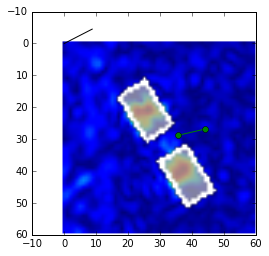

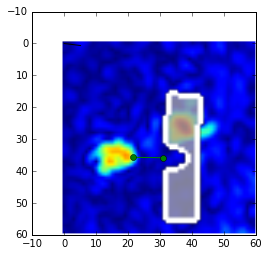

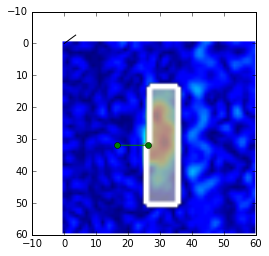

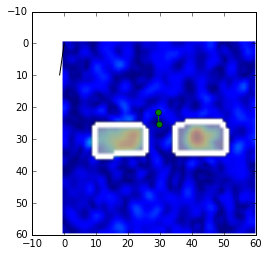

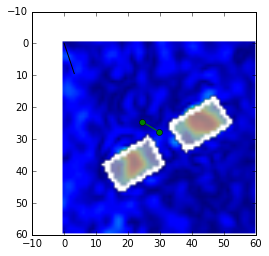

In [110]:
for row in results:
    
    (meshpoints, datablock, ans, axv0, guess, shift) = row
    trial_normal = normalize( ans[0][3:6] )
    trial_center = ans[0][0:3]
    

    si=trial_center[2].astype(int)

    ins = in_marker_model( meshpoints, thrive2ras(trial_center), trial_normal )

    mask = ins.reshape(datablock.shape)

    plt.figure(figsize=(4,4))
    plt.imshow(datablock[:,:,si])
    maskoverlay = np.zeros((mask.shape[0],mask.shape[1],4) ) 


    gr=np.gradient(mask[:,:,si])
    grIM=gr[0]**2 + gr[1]**2

    maskoverlay[mask[:,:,si]] = 0.8
    maskoverlay[grIM>0] = 1

    plt.imshow( maskoverlay)
    plt.plot([0,0 + 10*axv0[1]], [0,0 + 10*axv0[0]],'k')
    
    voxnormal = thrive2ras(trial_normal)
    voxnormal = apply_trfm(trial_normal, affine[0:3,0:3],0)
    nori = trial_center-shift
    ntip = trial_center-shift + (voxnormal)*10
    plt.plot([nori[1], ntip[1] ], [nori[0], ntip[0]], '-og')

In [486]:
ans

(array([  3.12696216e+02,   2.83929730e+02,   2.60000000e+01,
          6.00000000e-01,   5.55111512e-17,   4.00000000e-01]), 0)

In [69]:
sorted(w)

[0.0, 5225224.9022953073, 5359535.2736136978]

In [71]:
v[np.argsort(w),:]

array([[ 0.        ,  0.        ,  1.        ],
       [-0.93767668,  0.34750891,  0.        ],
       [-0.34750891, -0.93767668,  0.        ]])

In [72]:
v

array([[-0.93767668,  0.34750891,  0.        ],
       [-0.34750891, -0.93767668,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])